In [1]:
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import hub
from langchain.vectorstores import Chroma,FAISS
from langgraph.graph import END, StateGraph, START
from langchain_core.messages import BaseMessage
from pydantic import BaseModel,Field
from typing_extensions import TypedDict,Annotated,List
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings

from langchain_core.prompts import ChatPromptTemplate

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
URLS =  [
    "https://www.linkedin.com/pulse/parallel-execution-nodes-langgraph-enhancing-your-graph-prateek-qqwrc/",
    "https://www.linkedin.com/pulse/tool-calling-langchain-do-more-your-ai-agents-saurav-prateek-so20c",
]

In [3]:
DOCUMENT_GRADER_PROMPT = """
    You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

HALLUCINATION_GRADER_PROMPT = """
    You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 

    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.
"""

ANSWER_GRADER_PROMPT = """
    You are a grader assessing whether an answer addresses / resolves a question \n 
    Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question.
"""

In [4]:
import os 
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")

In [5]:
class AgentState(TypedDict):
    question:str 
    generation :str 
    documents:List[str]
    model:ChatGroq
    vector_store:Chroma
    hallucination:bool
    valid_answer:bool 
    
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# Data model for grading hallucinations
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# Data model for grading the final answer
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [6]:
def create_model(state:AgentState):
    state['model'] = ChatGroq(model="openai/gpt-oss-120b",temperature=0.3)
    return state

In [7]:
def build_vector_store(state:AgentState):
    docs = [WebBaseLoader(url).load() for url in URLS]
    docs_list = [item for sublist in docs for item in sublist]
    
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250,chunk_overlap=0)
    
    docs_splitter = text_splitter.split_documents(docs_list)
    
    vector_store = Chroma.from_documents(documents=docs_splitter,
                                         embedding=HuggingFaceEmbeddings(),
                                         collection_name="rag-collection")
    state["vector_store"] = vector_store.as_retriever()
    return state

In [8]:
def get_relevent_document(state:AgentState):
    question = state["question"]
    vector_store = state["vector_store"]
    
    documents = vector_store.get_relevant_documents(question)
    state["documents"] = documents
    return state

In [9]:
def grade_document(state:AgentState):
    question = state["question"]
    documents =state["documents"]
    
    str_llm_output = state["model"].with_structured_output(GradeDocuments)
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", DOCUMENT_GRADER_PROMPT),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )
    
    retriver_grader = grade_prompt | str_llm_output
    
    filter_documents = []
    for d in documents:
        score = retriver_grader.invoke({
            "question":question,
            "document":documents
        })
        grade = score.binary_score
        if grade == "yes":
            filter_documents.append(d)
        else:
            continue
        
        state["documents"] = filter_documents
        return state    


In [10]:
def decide_to_genrate(state:AgentState):
    filter_documents= state["documents"] 
    
    if not filter_documents:
        return "end"
    
    else:
        return "continue"

In [11]:
from langchain_core.output_parsers import StrOutputParser

In [12]:
def gernrate_answer(state:AgentState):
    question = state['question']
    documents = state["documents"]
    prompt = hub.pull("rlm/rag-prompt")
    
    chain = prompt|state["model"] |StrOutputParser()
    
    generate = chain.invoke({"context":documents,
                             "question":question})
    
    state["generation"] = generate
    
    return state
    

In [13]:
def check_hallucination(state:AgentState):
    documents = state['documents']
    generation = state['generation']
    
    str_llm_output = state['model'].with_structured_output(GradeHallucinations)
    hall_prompt = ChatPromptTemplate.from_messages([
        ("system",HALLUCINATION_GRADER_PROMPT),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ])
    
    retriver_chain = hall_prompt|str_llm_output
    
    score = retriver_chain.invoke({"documents":documents,
                                   "generation":generation})
    
    grade = score.binary_score
    
    if grade =="yes":
        state["hallucination"] = False
    
    else:
        state["hallucination"] = True
        
    return state        

In [14]:
def grade_answer(state:AgentState):
    question  = state["question"]
    generation = state["generation"]
    
    str_llm_output = state['model'].with_structured_output(GradeAnswer)
    answer_prompt = ChatPromptTemplate.from_messages([
        ("system",ANSWER_GRADER_PROMPT),
        ("human","User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]) 
    
    chain = answer_prompt| str_llm_output
    score  = chain.invoke({"question":question,"generation":generation})
    
    grade = score.binary_score
    if grade=="yes":
        state["valid_answer"] = True
    
    else:
        state["valid_answer"] = False
    return state        
    

In [15]:
def build_graph():
    workflow = StateGraph(AgentState)

    # Define the nodes
    workflow.add_node("create_model", create_model)
    workflow.add_node("build_vector_store", build_vector_store)
    workflow.add_node("get_relevant_documents", get_relevent_document)
    workflow.add_node("grade_documents", grade_document)
    workflow.add_node("generate_answer", gernrate_answer)   # ✅ corrected
    workflow.add_node("check_for_hallucination", check_hallucination)
    workflow.add_node("grade_answer", grade_answer)


    # Build graph
    workflow.add_edge(START, "create_model")
    workflow.add_edge("create_model", "build_vector_store")
    workflow.add_edge("build_vector_store", "get_relevant_documents")
    workflow.add_edge("get_relevant_documents", "grade_documents")
    workflow.add_conditional_edges(
        "grade_documents",
        decide_to_genrate,
        {
            "continue": "generate_answer",
            "end": END,
        },
    )
    workflow.add_edge("generate_answer", "check_for_hallucination")
    workflow.add_edge("check_for_hallucination", "grade_answer")

    # Compile
    return workflow.compile()

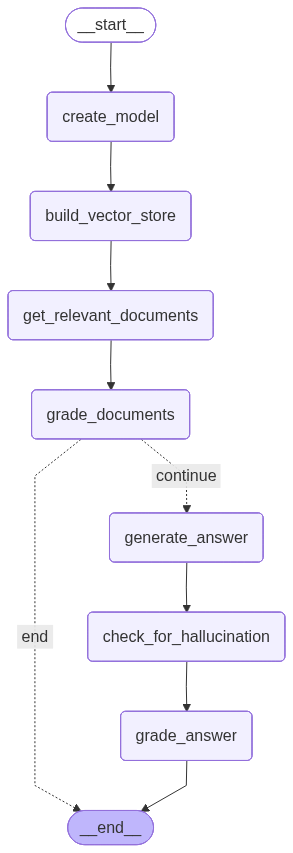

In [16]:
from IPython.display import Image
graph = build_graph()
Image(graph.get_graph().draw_mermaid_png())


In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")


In [18]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"

In [22]:
response = graph.invoke({
    "question": "what is the tool calling?"
})

print("---FINAL RESPONSE---")

if 'hallucination' in response.keys() and response['hallucination']:
    print("Model Hallucinated, generation is not grounded in documents. \n")

if 'valid_answer' in response.keys() and not response['valid_answer']:
    print("Answer is not valid for the question. \n")

if 'generation' in response.keys():
    print("Generated Answer: \n")
    print(response['generation'])

d:\anaconda\envs\ai-agents\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


---FINAL RESPONSE---
Generated Answer: 

Tool calling is the capability of an AI agent to invoke external utilities, APIs, or functions to perform specific actions or retrieve data. In LangChain, this lets the model dynamically call these tools during a conversation or workflow. It extends the agent’s abilities beyond pure text generation.
